# IRIS data に対するSelf-Attention

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# Irisデータセットのロード
iris = load_iris()
X = torch.tensor(iris.data, dtype=torch.float32)
y = torch.tensor(iris.target, dtype=torch.long)

# データセットの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoaderの作成 (学習データ全体を評価するためにbatch_size=len(X_train)とする)
train_dataset = TensorDataset(X_train, y_train)
train_loader_all = DataLoader(train_dataset, batch_size=len(X_train), shuffle=False)
train_loader_batch = DataLoader(train_dataset, batch_size=16, shuffle=True) # 学習用

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16)

In [43]:
# ニューラルネットワークの定義
class IrisClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=1):
        super(IrisClassifier, self).__init__()
        self.self_attn = nn.MultiheadAttention(input_dim, num_heads, batch_first=True)
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        attn_output, attn_output_weights = self.self_attn(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        attn_output = attn_output.squeeze(1)
        logits = self.linear(attn_output)
        return logits, attn_output_weights

In [44]:
# モデルのインスタンス化
#input_dim = X_train.shape[1]
input_dim = 1
num_classes = len(torch.unique(y))
model = IrisClassifier(input_dim, num_classes)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 学習曲線を保存するためのリスト
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 学習ループ
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader_batch:
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 1エポック終了後の訓練データ全体に対する評価
    model.eval()
    with torch.no_grad():
        for inputs, labels in train_loader_all:
            train_outputs, _ = model(inputs)
            train_loss = criterion(train_outputs, labels)
            _, train_predicted = torch.max(train_outputs.data, 1)
            train_total = labels.size(0)
            train_correct = (train_predicted == labels).sum().item()

        for inputs, labels in test_loader:
            test_outputs, _ = model(inputs)
            test_loss = criterion(test_outputs, labels)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total = labels.size(0)
            test_correct = (test_predicted == labels).sum().item()

    avg_train_loss = train_loss.item()
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    avg_test_loss = test_loss.item()
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Training finished.')

AssertionError: was expecting embedding dimension of 1, but got 4

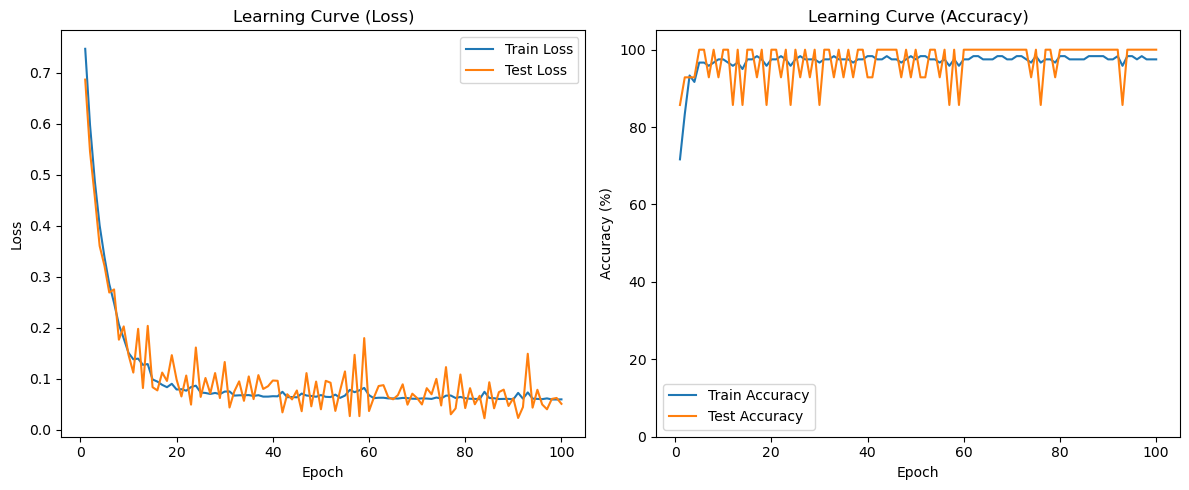

In [ ]:
# 学習曲線のプロット
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.ylim(0, 105)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve (Accuracy)')
plt.legend()
plt.tight_layout()
plt.show()

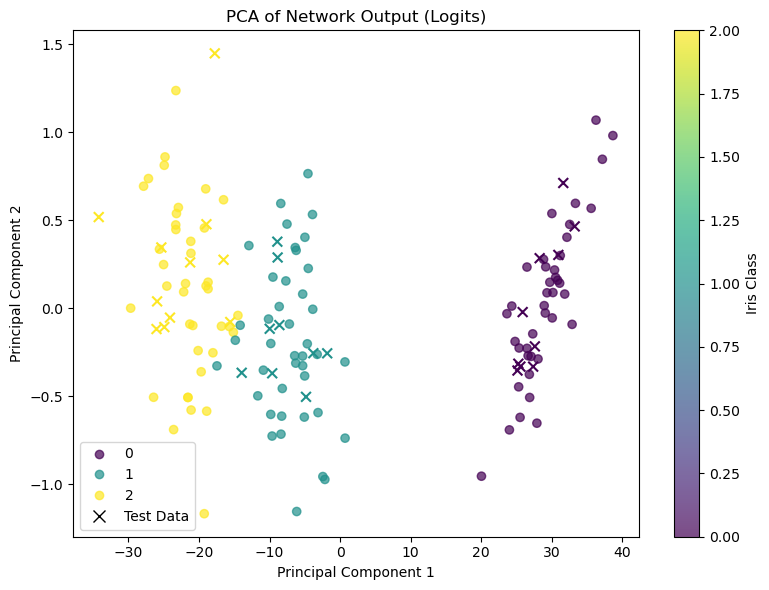

In [ ]:
# 訓練データのロジットを取得
model.eval()
train_logits = []
train_labels_all = []
with torch.no_grad():
    for inputs, labels in train_loader_all:
        outputs, _ = model(inputs)
        train_logits.append(outputs.numpy())
        train_labels_all.append(labels.numpy())
train_logits = np.concatenate(train_logits, axis=0)
train_labels_all = np.concatenate(train_labels_all, axis=0)

# テストデータのロジットを取得
test_logits = []
test_labels_all = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs, _ = model(inputs)
        test_logits.append(outputs.numpy())
        test_labels_all.append(labels.numpy())
test_logits = np.concatenate(test_logits, axis=0)
test_labels_all = np.concatenate(test_labels_all, axis=0)

# PCAによる次元削減
pca = PCA(n_components=2)
all_logits = np.vstack((train_logits, test_logits))
pca.fit(all_logits)
train_pca = pca.transform(train_logits)
test_pca = pca.transform(test_logits)

# 可視化
plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels_all, cmap='viridis', label='Train Data', alpha=0.7)
plt.scatter(test_pca[:, 0], test_pca[:, 1], c=test_labels_all, cmap='viridis', marker='x', s=50, label='Test Data')

# カラーバーと凡例
cbar = plt.colorbar(scatter)
cbar.set_label('Iris Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Network Output (Logits)')

# クラスごとの凡例を追加
handles, labels = scatter.legend_elements()
plt.legend(handles + [plt.Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=8, label='Test Data')],
           labels + ['Test Data'])

plt.tight_layout()
plt.show()

In [ ]:
# いくつかのサンプルに対するSelf-attentionの計算と表示
model.eval()
with torch.no_grad():
    # 最初のバッチのデータを取り出す
    data_iter = iter(train_loader_all)
    sample_inputs, sample_labels = next(data_iter)

    # 最初の5つのサンプルに対してSelf-attentionを計算
    num_samples_to_show = min(5, sample_inputs.shape[0])
    for i in range(num_samples_to_show):
        input_sample = sample_inputs[i].unsqueeze(0) # バッチ次元を追加
        _, attention_weights = model(input_sample)
        print(f"Sample {i+1} - Attention Weights:\n{attention_weights.squeeze().numpy()}")

Sample 1 - Attention Weights:
1.0
Sample 2 - Attention Weights:
1.0
Sample 3 - Attention Weights:
1.0
Sample 4 - Attention Weights:
1.0
Sample 5 - Attention Weights:
1.0


In [ ]:
# いくつかのサンプルに対するSelf-attentionの計算と表示
model.eval()
with torch.no_grad():
    # 最初のバッチのデータを取り出す
    data_iter = iter(train_loader_all)
    sample_inputs, sample_labels = next(data_iter)

    # 最初の5つのサンプルに対してSelf-attentionを計算
    num_samples_to_show = min(5, sample_inputs.shape[0])
    for i in range(num_samples_to_show):
        input_sample = sample_inputs[i].unsqueeze(0) # バッチ次元を追加
        _, attention_weights = model(input_sample)
        print(f"Sample {i+1} - Attention Weights:\n{attention_weights.squeeze().numpy()}")

    print("-" * 30)

    # 訓練データ中の各クラスのサンプルに対するSelf-attentionの値の平均を計算
    all_train_attention_weights = []
    all_train_labels = []
    for inputs, labels in train_loader_all:
        _, attention_weights = model(inputs)
        all_train_attention_weights.append(attention_weights.squeeze().numpy())
        all_train_labels.append(labels.numpy())

    all_train_attention_weights = np.concatenate(all_train_attention_weights, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)

    mean_attention_per_class = {}
    for class_id in torch.unique(y).numpy():
        class_indices = np.where(all_train_labels == class_id)[0]
        class_attention_weights = all_train_attention_weights[class_indices]
        mean_attention = np.mean(class_attention_weights, axis=0)
        mean_attention_per_class[f"Class {class_id}"] = mean_attention
        print(f"Mean Attention Weights for Class {class_id}:\n{mean_attention}")

    print("-" * 30)

    # 全結合層の重みをプリント
    for name, param in model.named_parameters():
        if name == 'linear.weight':
            print(f"Linear Layer Weights:\n{param.detach().numpy()}")

Sample 1 - Attention Weights:
1.0
Sample 2 - Attention Weights:
1.0
Sample 3 - Attention Weights:
1.0
Sample 4 - Attention Weights:
1.0
Sample 5 - Attention Weights:
1.0
------------------------------
Mean Attention Weights for Class 0:
1.0
Mean Attention Weights for Class 1:
1.0
Mean Attention Weights for Class 2:
1.0
------------------------------
Linear Layer Weights:
[[ 1.3058231   0.5579071  -0.9454476   1.1917715 ]
 [-0.51712567  0.9479766  -0.4094606   0.3778027 ]
 [-0.17609079 -1.0566603   0.8417623  -0.77221394]]
